<a href="https://colab.research.google.com/github/gfxluffy/Visualizing-Filters-of-a-CNN-using-Tensorflow/blob/main/Visualizing_Filters_of_a_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Visualizing Filters of a Convolutional Neural Network

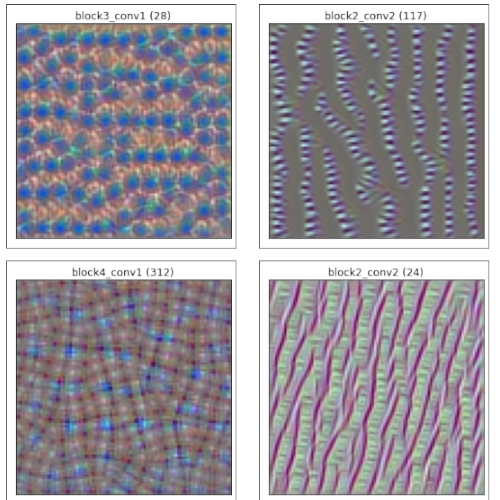

## Task 2: Downloading the Model

In [1]:
import tensorflow as tf
import random
import matplotlib.pyplot as plt

print('Tensorflow version', tf.__version__)

Tensorflow version 2.7.0


In [2]:
model = tf.keras.applications.vgg16.VGG16(
    include_top=False,        # Final few FC layers will not be included in the model
    weights='imagenet',       # Download the model with weights trained on imagenet dataset
    input_shape=(96, 96, 3),  # 96 rows, 96 cols, 3 channels
)

model.summary()
# In CNN, a lot of simple features are learned at the lower conv layers.
# Block 1 & 2 will have simple & straightforward features being learned
# Block 3 onwards will have more complex and complicated patterns being learned by the filters
# -- these are the layers which are more directly impacting the classification

58900480/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 96, 96, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 96, 96, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 48, 48, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 48, 48, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 48, 48, 128)       147584    
                                                              

## Task 3: Get Layer Output

In [3]:
# Create submodels to get layer output
def get_submodel(layer_name):
  return tf.keras.models.Model(
      model.input,
      model.get_layer(layer_name).output
  )

get_submodel('block1_conv2').summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 96, 96, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 96, 96, 64)        36928     
                                                                 
Total params: 38,720
Trainable params: 38,720
Non-trainable params: 0
_________________________________________________________________


## Task 4: Image Visualization

In [4]:
# Idea: Use pretrained model and run an image thru it and try to understand what the filter is looking for in the input
# Take a look at the output of first filter at block1_conv2 layer and optimize input image in a way
# that it gradually moves towards showing us the kind of visual features that that particular filter is maximally activated at

# Create function for creating random images that we'll use as input
def create_image():
  return tf.random.uniform((96, 96, 3), minval=-0.5, maxval=0.5)

def plot_image(image, title='random'):
  image = image - tf.math.reduce_min(image) # If mean is centered around 0 and we have some values which are negative, we're adding that to the image (all positive values)
  image = image / tf.math.reduce_max(image) # Scale so that all values are 0 to 1 to plot image easily
  plt.imshow(image)
  plt.xticks([])
  plt.yticks([])
  plt.title(title)
  plt.show()

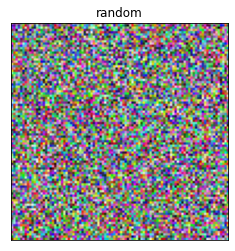

In [5]:
image = create_image()
plot_image(image)

## Task 5: Training Loop

In [6]:
# Show input that'll maximally activate filter,
# essentially giving us an insight into what that specific filter is looking for in the input images

def visualize_filter(layer_name, f_index=None, iters=50):
  submodel = get_submodel(layer_name)
  num_filters = submodel.output.shape[-1]

  if f_index is None:
    f_index = random.randint(0, num_filters - 1)
  assert num_filters > f_index, 'f_index is out of bounds'

  image = create_image()
  verbose_step = int(iters / 10)  # To keep track of loss

  # Gradient Ascent (Instead of descending down to find minima, we maximize lost value which will be the output of the submodel at this filter)
  for i in range(0, iters):
    with tf.GradientTape() as tape:     # Keep track of image
      tape.watch(image)                 # Watch image in the GradientTape context (look at computations that'll happen on the image)
      out = submodel(tf.expand_dims(image, axis=0))[:,:,:,f_index]  # Include first dim since it's what the model expects (batch_size=1); Look at filter output
      loss = tf.math.reduce_mean(out)   # -> What we're trying to maximize
    grads = tape.gradient(loss, image)
    grads = tf.math.l2_normalize(grads) # So that the grads are not taking any wild step in any direction
    image += grads  * 10                # Update image; Use large learning rate to speed up process since grads can be pretty small

    if (i+1) % verbose_step == 0:
      print(f'Iteration: {i+1}, Loss: {loss.numpy():.4f}')

  plot_image(image, f'{layer_name}, {f_index}')

## Task 6: Final Results

In [7]:
print([layer.name for layer in model.layers if 'conv' in layer.name])

['block1_conv1', 'block1_conv2', 'block2_conv1', 'block2_conv2', 'block3_conv1', 'block3_conv2', 'block3_conv3', 'block4_conv1', 'block4_conv2', 'block4_conv3', 'block5_conv1', 'block5_conv2', 'block5_conv3']


Iteration: 10, Loss: 41.7537
Iteration: 20, Loss: 73.6163
Iteration: 30, Loss: 105.4467
Iteration: 40, Loss: 137.4351
Iteration: 50, Loss: 169.5791
Iteration: 60, Loss: 201.8228
Iteration: 70, Loss: 234.1127
Iteration: 80, Loss: 266.4443
Iteration: 90, Loss: 298.8152
Iteration: 100, Loss: 331.2318


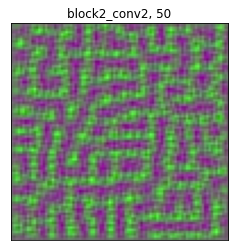

In [28]:
layer_name = 'block2_conv2' #@param ['block1_conv1', 'block1_conv2', 'block2_conv1', 'block2_conv2', 'block3_conv1', 'block3_conv2', 'block3_conv3', 'block4_conv1', 'block4_conv2', 'block4_conv3', 'block5_conv1', 'block5_conv2', 'block5_conv3']

visualize_filter(layer_name, iters=100)

In [8]:
# Some filters may not have any specific patterns -- it's possible, since we're dealing with random images, that certain filters are not activated enough to begin with to be able to perform G.A. on (might need more sophisticated ideas for G.A.)
# Also dead filters -- they can be removed from the network since they dont really perform any specific function